In [1]:
# !pip install lxml

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 500
plt.rcParams['font.size'] = '16'
sns.set_style('whitegrid')

In [3]:
link = pd.read_html('https://genshin-impact.fandom.com/wiki/Wishes/History')
df = link[1]
df = df.dropna()

In [4]:
df.Featured = df.Featured.str.split().apply(lambda x: x[0])
df = df.drop('Wish', axis=1)

In [5]:
df = df[df.Featured != '—']

In [6]:
df.head()

,Featured,Duration
0,Venti,"September 28, 2020 – October 18, 2020"
4,Klee,"October 20, 2020 – November 10, 2020"
6,Tartaglia,"November 11, 2020 – December 1, 2020"
8,Zhongli,"December 1, 2020 – December 22, 2020"
10,Albedo,"December 23, 2020 – January 12, 2021"


In [7]:
paired_df = (df.groupby('Duration').Featured.count() == 2).reset_index()
paired_df = paired_df.rename(
    columns={
        'Featured': 'Paired'
    }
)
paired_df.Paired = paired_df.Paired.astype(int)

df = pd.merge(df, paired_df, left_on='Duration' \
         , right_on='Duration', how='inner')

In [8]:
df.head()

,Featured,Duration,Paired
0,Venti,"September 28, 2020 – October 18, 2020",0
1,Klee,"October 20, 2020 – November 10, 2020",0
2,Tartaglia,"November 11, 2020 – December 1, 2020",0
3,Zhongli,"December 1, 2020 – December 22, 2020",0
4,Albedo,"December 23, 2020 – January 12, 2021",0


In [9]:
df.Duration = df.Duration.apply(lambda x: x.split('–')[0])
df['Date'] = pd.to_datetime(df.Duration, infer_datetime_format=True)
df = df.drop('Duration', axis=1)

In [10]:
df.isna().any()

Featured    False
Paired      False
Date        False
dtype: bool

In [11]:
df.head()

,Featured,Paired,Date
0,Venti,0,2020-09-28
1,Klee,0,2020-10-20
2,Tartaglia,0,2020-11-11
3,Zhongli,0,2020-12-01
4,Albedo,0,2020-12-23


In [12]:
df = df.rename(
    columns={
        'Featured': 'Character'
    }
)

In [13]:
df.head()

,Character,Paired,Date
0,Venti,0,2020-09-28
1,Klee,0,2020-10-20
2,Tartaglia,0,2020-11-11
3,Zhongli,0,2020-12-01
4,Albedo,0,2020-12-23


In [14]:
df['CurrentRerunDelta'] = pd.to_datetime(datetime.date(datetime.now())) - df.Date

In [15]:
df.head()

,Character,Paired,Date,CurrentRerunDelta
0,Venti,0,2020-09-28,581 days
1,Klee,0,2020-10-20,559 days
2,Tartaglia,0,2020-11-11,537 days
3,Zhongli,0,2020-12-01,517 days
4,Albedo,0,2020-12-23,495 days


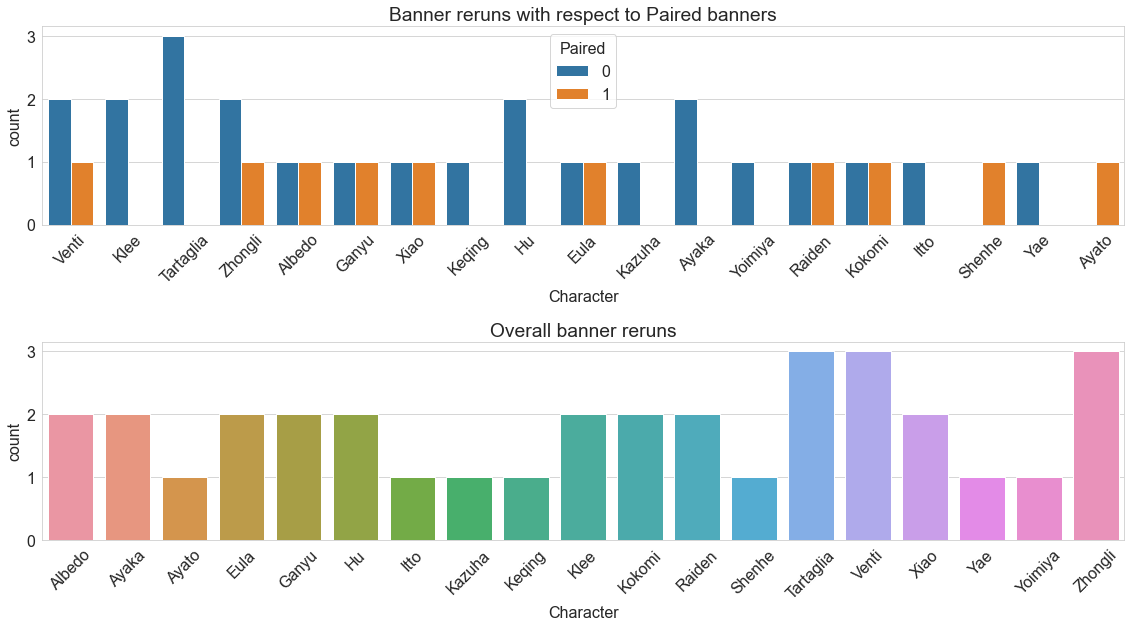

In [16]:
banner_counts = df.groupby('Character').Date.count()

fig = plt.figure(figsize=(16, 9))

ax1 = fig.add_subplot(2, 1, 1)
sns.countplot(x=df.Character, hue=df.Paired)
plt.title('Banner reruns with respect to Paired banners')
plt.xticks(rotation=45)



ax2 = fig.add_subplot(2, 1, 2)
sns.barplot(x=banner_counts.index, y=banner_counts)
plt.title('Overall banner reruns')
plt.xticks(rotation=45)
plt.ylabel('count')

plt.tight_layout()

In [17]:
tables_2 = pd.read_html('https://www.bulletinsun.com/2022/01/'
                        'Genshin-Impact-pick-rates-Full-list-of-each-Genshin-Impact-character.html')

In [18]:
pick_rate_df = tables_2[0]
pick_rate_df = pick_rate_df.loc[1:]
pick_rate_df.columns = ['Rank', 'Character', 'Element', 'Popularity']

pick_rate_df = pick_rate_df.drop(['Rank'], axis=1)
pick_rate_df.Character = pick_rate_df.Character.apply(lambda x: x.split()[0])

In [19]:
df = pd.merge(df, pick_rate_df)

In [20]:
df.isna().any()

Character            False
Paired               False
Date                 False
CurrentRerunDelta    False
Element              False
Popularity           False
dtype: bool

In [21]:
df.head()

,Character,Paired,Date,CurrentRerunDelta,Element,Popularity
0,Venti,0,2020-09-28,581 days,Anemo,83%
1,Venti,0,2021-03-17,411 days,Anemo,83%
2,Venti,1,2022-03-30,33 days,Anemo,83%
3,Klee,0,2020-10-20,559 days,Pyro,16.3%
4,Klee,0,2021-06-09,327 days,Pyro,16.3%


In [22]:
df.Popularity = df.Popularity.apply(lambda x: float(x[:-1]))

In [23]:
df.head()

,Character,Paired,Date,CurrentRerunDelta,Element,Popularity
0,Venti,0,2020-09-28,581 days,Anemo,83.0
1,Venti,0,2021-03-17,411 days,Anemo,83.0
2,Venti,1,2022-03-30,33 days,Anemo,83.0
3,Klee,0,2020-10-20,559 days,Pyro,16.3
4,Klee,0,2021-06-09,327 days,Pyro,16.3


In [24]:
unique_df = df.copy().drop_duplicates('Character', keep='last')

In [25]:
banner_counts = df.groupby('Character').Date.count().reset_index()

banner_counts = banner_counts.rename(
    columns={
        'Date': 'Appearances'
    }
)

df = pd.merge(df, banner_counts)

In [26]:
from datetime import timedelta

df['NextRerunDelta'] = df.groupby('Character').Date.diff()
df.NextRerunDelta = df.NextRerunDelta.fillna(timedelta(0))

df['MaxRerunDelta'] = df.groupby('Character').NextRerunDelta.transform('max')
df = df.drop('NextRerunDelta', axis=1)

# df[df.MaxRerunDelta == timedelta(0)].MaxRerunDelta = df.LatestRerunDelta

In [27]:
unique_df = df.drop_duplicates('Character', keep='last')
unique_df = unique_df[df.Popularity > 10]

In [28]:
df.dtypes

Character                     object
Paired                         int64
Date                  datetime64[ns]
CurrentRerunDelta    timedelta64[ns]
Element                       object
Popularity                   float64
Appearances                    int64
MaxRerunDelta        timedelta64[ns]
dtype: object

In [29]:
df

,Character,Paired,Date,CurrentRerunDelta,Element,Popularity,Appearances,MaxRerunDelta
0,Venti,0,2020-09-28,581 days,Anemo,83.0,3,378 days
1,Venti,0,2021-03-17,411 days,Anemo,83.0,3,378 days
2,Venti,1,2022-03-30,33 days,Anemo,83.0,3,378 days
3,Klee,0,2020-10-20,559 days,Pyro,16.3,2,232 days
4,Klee,0,2021-06-09,327 days,Pyro,16.3,2,232 days
5,Zhongli,0,2020-12-01,517 days,Geo,91.5,3,272 days
6,Zhongli,0,2021-04-28,369 days,Geo,91.5,3,272 days
7,Zhongli,1,2022-01-25,97 days,Geo,91.5,3,272 days
8,Albedo,0,2020-12-23,495 days,Geo,74.2,2,336 days
9,Albedo,1,2021-11-24,159 days,Geo,74.2,2,336 days


In [30]:
unique_df.MaxRerunDelta = np.where(unique_df.MaxRerunDelta == timedelta(0) \
                                   , unique_df.CurrentRerunDelta, unique_df.MaxRerunDelta)

In [31]:
unique_df

,Character,Paired,Date,CurrentRerunDelta,Element,Popularity,Appearances,MaxRerunDelta
2,Venti,1,2022-03-30,33 days,Anemo,83.0,3,378 days
4,Klee,0,2021-06-09,327 days,Pyro,16.3,2,232 days
7,Zhongli,1,2022-01-25,97 days,Geo,91.5,3,272 days
9,Albedo,1,2021-11-24,159 days,Geo,74.2,2,336 days
11,Ganyu,1,2022-01-25,97 days,Cryo,76.2,2,378 days
13,Xiao,1,2022-01-05,117 days,Anemo,50.4,2,336 days
16,Hu,0,2021-11-02,181 days,Pyro,73.8,2,245 days
18,Eula,1,2021-11-24,159 days,Cryo,60.2,2,190 days
19,Kazuha,0,2021-06-29,307 days,Anemo,95.2,1,307 days
21,Ayaka,0,2022-04-19,13 days,Cryo,87.8,2,272 days


In [32]:
unique_df.MaxRerunDelta.replace(to_replace=timedelta(0), value=timedelta(1))

2    378 days
4    232 days
7    272 days
9    336 days
11   378 days
13   336 days
16   245 days
18   190 days
19   307 days
21   272 days
22   265 days
24   188 days
26   168 days
27   117 days
Name: MaxRerunDelta, dtype: timedelta64[ns]

In [33]:
unique_df.sort_values(by=['CurrentRerunDelta', 'Popularity', 'Appearances'] \
                      , ascending=[False, False, True])

,Character,Paired,Date,CurrentRerunDelta,Element,Popularity,Appearances,MaxRerunDelta
4,Klee,0,2021-06-09,327 days,Pyro,16.3,2,232 days
19,Kazuha,0,2021-06-29,307 days,Anemo,95.2,1,307 days
22,Yoimiya,0,2021-08-10,265 days,Pyro,40.1,1,265 days
16,Hu,0,2021-11-02,181 days,Pyro,73.8,2,245 days
9,Albedo,1,2021-11-24,159 days,Geo,74.2,2,336 days
18,Eula,1,2021-11-24,159 days,Cryo,60.2,2,190 days
27,Shenhe,1,2022-01-05,117 days,Cryo,58.2,1,117 days
13,Xiao,1,2022-01-05,117 days,Anemo,50.4,2,336 days
7,Zhongli,1,2022-01-25,97 days,Geo,91.5,3,272 days
11,Ganyu,1,2022-01-25,97 days,Cryo,76.2,2,378 days


<AxesSubplot:>

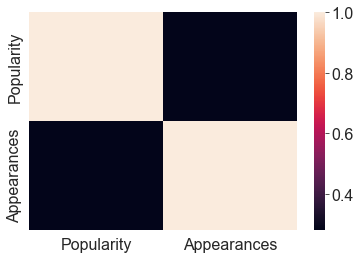

In [34]:
sns.heatmap(unique_df[['Popularity', 'Appearances']].corr())

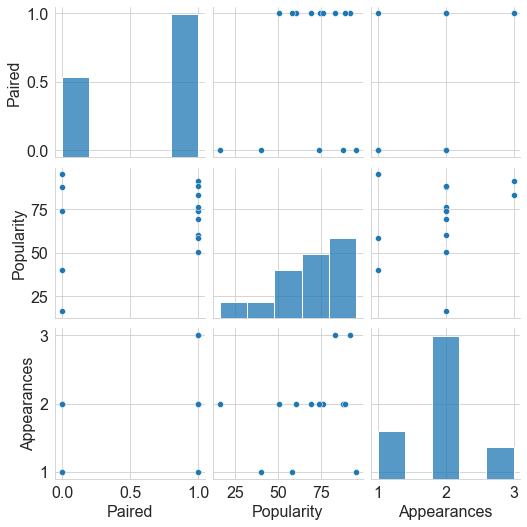

In [35]:
sns.pairplot(unique_df)

<AxesSubplot:title={'center':"Banners' count with respect to elements"}, xlabel='Element', ylabel='count'>

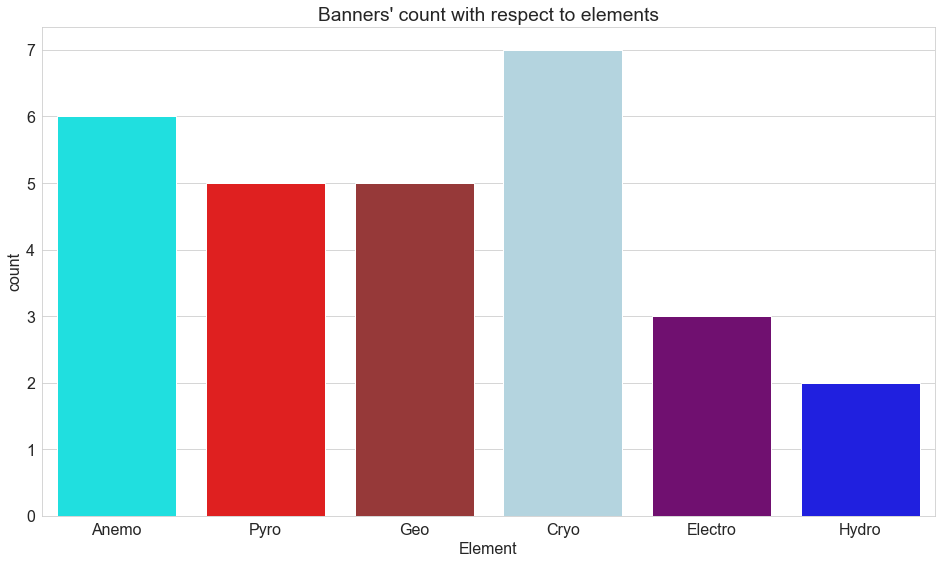

In [36]:
fig = plt.figure(figsize=(16, 9))

plt.title("Banners' count with respect to elements")
colors = ['cyan', 'red', 'brown', 'lightblue', 'purple', 'blue']
sns.countplot(x=df.Element, palette=colors)

<AxesSubplot:xlabel='Popularity', ylabel='Appearances'>

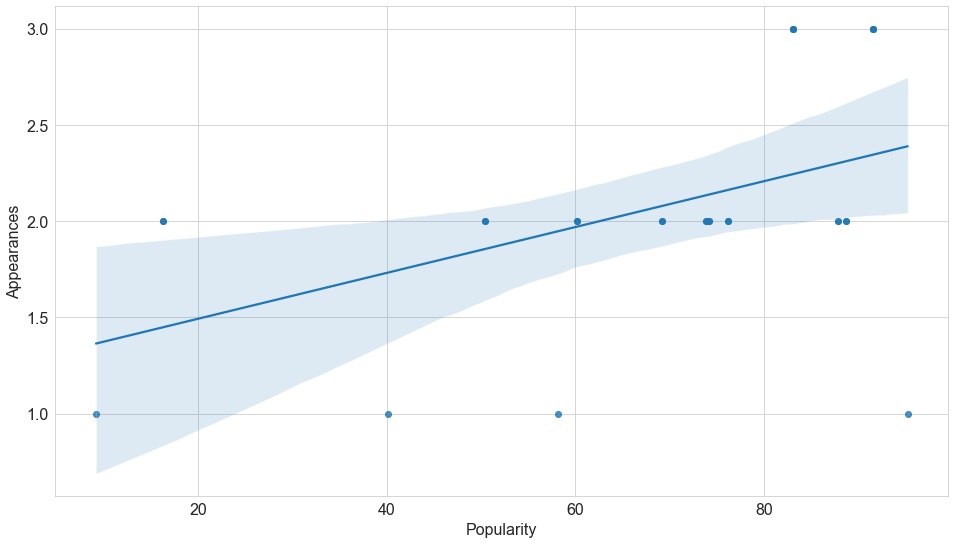

In [37]:
fig = plt.figure(figsize=(16, 9))

sns.regplot(df.Popularity, df.Appearances)